In [176]:
import pandas as pd 
import numpy as np 
import evoVAE.utils.metrics as mt 
import evoVAE.utils.seq_tools as st
from numba import njit, prange, jit
import random
#pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

In [ ]:
PATH = "/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/A4_HUMAN_Seuma_2022.csv"

def split_by_mutations(dms_data):
    """
    Create a subset of the mutation DataFrames based on how many mutations
    are in the variant.

    Return:
    A dictionary mapping mutation count to subset dataframe
    """

    # define a function for counting mutations
    splitter = lambda x: len(x.split(":"))
    dms_data["mut_count"] = dms_data["mutant"].apply(splitter)

    subframes = dict()
    for count in dms_data["mut_count"].unique():
        subframes[count] = dms_data.loc[dms_data["mut_count"] == count]

    return subframes

dms = pd.read_csv(PATH)
dms.head()

subframe = split_by_mutations(dms)
subframe[2].shape

In [ ]:
#aln = st.read_aln_file("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_extants_no_dupes.fasta", encode=False)
aln = st.read_aln_file("/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/a4_extants_no_dupes.fasta", encode=False)
#aln.drop(columns=["encoding"], inplace=True)
#aln.head()
aln.to_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/a4_extants_no_dupes.pkl")

In [ ]:
aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants_no_dupes.pkl")
aln.head()

In [357]:

def process_file_path(file_path):
    groups = [x for x in os.listdir(file_path) if x != ".DS_Store"]
    dirs = [file_path + x + "/" for x in os.listdir(file_path) if x != ".DS_Store"]

    return groups, dirs


def plot_clustering_loss(file_path, figure_name, rows, columns):

    groups, dirs = process_file_path(file_path)

    # Prepare the figure
    fig, axes = plt.subplots(rows, columns, figsize=(4, 2))  # 2 rows, 5 columns

    # Loop through groups and images
    # Two rows
    for col in range(columns):  # Five columns
        sampled = []
        for row in range(rows):

            to_show = random.randint(1, 15)
            while to_show in sampled:
                to_show = random.randint(1, 15)
            
            sampled.append(to_show)
            
            image_path = dirs[col] + f"{groups[col]}_extants_r{to_show}/loss.png"
            
            # Load and display the image
            img = Image.open(image_path)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')

    # Adjust layout
    # Reduce vertical space between subplots
    plt.subplots_adjust(hspace=0.01, wspace=0.01)  # Adjust vertical space between subplots (default is 0.2)
    plt.savefig(figure_name, dpi=800, bbox_inches='tight')
    plt.show()

def plot_standard_loss(file_path, figure_name, rows = 3, columns = 3):

    groups, dirs = process_file_path(file_path)

    # Prepare the figure
    fig, axes = plt.subplots(rows, columns, figsize=(4, 2)) 

    # Loop through groups and images
    # Two rows
    for col in range(columns):  # Five columns
        sampled = []
        for row in range(rows):

            to_show = random.randint(1, 15)
            while to_show in sampled:
                to_show = random.randint(1, 15)
            
            sampled.append(to_show)
            
            image_path = dirs[col] + f"{groups[col]}_r{to_show}/loss.png"
            
            # Load and display the image
            img = Image.open(image_path)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')

    # Adjust layout
    # Reduce vertical space between subplots
    plt.subplots_adjust(hspace=0.01, wspace=0.01)  # Adjust vertical space between subplots (default is 0.2)
    plt.savefig(figure_name, dpi=800, bbox_inches='tight')
    plt.show()

def combine_standard_replicates(file_path):
    
    groups, dirs = process_file_path(file_path)

    df_list = []
    for r in range(1, 16):
        for g, group in enumerate(groups):
            file = dirs[g] + f"{groups[g]}_r{r}/zero_shot_all_variants_final_metrics.csv"
            df_list.append(pd.read_csv(file))

    # #all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
    results = pd.concat(df_list, ignore_index=True)

    print(results.shape)
    return results

def combine_clustering_replicates(file_path):

    groups, dirs = process_file_path(file_path)

    df_list = []
    for r in range(1, 15):
        for g, group in enumerate(groups):
            file = f"{file_path + groups[g]}/{groups[g]}_extants_r{r}/zero_shot_all_variants_final_metrics.csv"
            df_list.append(pd.read_csv(file))

    # #all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
    cluster_results = pd.concat(df_list, ignore_index=True)
    print(cluster_results.shape)

    return cluster_results

def get_standard_label(lab):
        data = lab.split("/")[1].split("_")
        if len(data) == 3:
            # anc or extant
            return data[1]
        else:
            return "_".join(data[1:-1])
        

def plot_standard_metrics(std_results, protein_name):

    # use unique id to work out which sample it is 
    # get which replicate it is 
    get_rep = lambda x: int(x.split("/")[1].split("_")[-1][1:])
    # get extants, ancestor or anc_extant label in sample
   

    rep = std_results["unique_id"].apply(get_rep)

    ext_prop = std_results["unique_id"].apply(get_standard_label)

    std_results["replicate"] = rep
    std_results["sample"] = ext_prop

    labels = std_results["sample"].unique()
    labels.sort()
    
    points = [std_results.loc[std_results["sample"] == prop] for prop in labels]

    metrics = ["spearman_rho", "top_k_recall", "ndcg", "roc_auc", "pearson"]
    for m in metrics:

        
        means = [point[m].mean() for point in points]
        std_devs = [point[m].std() for point in points] 

        x_pos = np.arange(len(labels))

        fig, ax = plt.subplots()

        # Create bars
        bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

        for i, point in enumerate(points):
            ax.scatter([i]*len(point), point[m], color='red', zorder=3, alpha=0.5)


        # Add labels
        ax.set_xlabel('Extant sample proportion')
        ax.set_ylabel(f'Mean {m}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels)

        #ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
        if m == "pearson":
            ax.set_title(f'{protein_name}: Average parwise covariance Pearson\'s correlation')
        else: 
            ax.set_title(f'{protein_name}: Average {m}')


        # Add a grid for better readability
        ax.yaxis.grid(True)

        # Save the figure and show
        plt.tight_layout()
        plt.show()

    

def plot_clustering_metrics(cluster_results, protein_name):

    # get which replicate it is 
    get_rep = lambda x: int(x.split("/")[1].split("_")[-1][1:])
    # get proportion of extants in sample
    get_ex = lambda x: float(x.split("/")[1].split("_")[1]) 


    rep = cluster_results["unique_id"].apply(get_rep)

    ext_prop = cluster_results["unique_id"].apply(get_ex)

    cluster_results["replicate"] = rep
    cluster_results["sample"] = ext_prop

    labels = cluster_results["sample"].unique()
    labels.sort()
    
    points = [cluster_results.loc[cluster_results["sample"] == prop] for prop in labels]

    metrics = ["spearman_rho", "top_k_recall", "ndcg", "roc_auc", "pearson"]
    for m in metrics:

        
        means = [point[m].mean() for point in points]
        std_devs = [point[m].std() for point in points] 

        x_pos = np.arange(len(labels))

        fig, ax = plt.subplots()

        # Create bars
        bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

        for i, point in enumerate(points):
            ax.scatter([i]*len(point), point[m], color='red', zorder=3, alpha=0.5)


        # Add labels
        ax.set_xlabel('Extant sample proportion')
        ax.set_ylabel(f'Mean {m}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels)

        #ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
        if m == "pearson":
            ax.set_title(f'{protein_name}: Average parwise covariance Pearson\'s correlation')
        else: 
            ax.set_title(f'{protein_name}: Average {m}')


        # Add a grid for better readability
        ax.yaxis.grid(True)

        # Save the figure and show
        plt.tight_layout()
        plt.show()



# GB1 clustering 

#### Creating replicates

1. Take output from mmSeqs which has clusters 
2. Separate into representative clusters 
3. Sample without replcement to make sample sizes of 10,000

In [ ]:
# this is the dataframe where all sampling will take place from, indices that are sampled will refer to this dataset
aln: pd.DataFrame = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/encoded_weighted/gb1_ancestors_extants_encoded_weighted_no_dupes.pkl")
aln = aln.drop_duplicates(subset=['sequence'])
#aln = aln.sample(frac=0.2)
print(aln.shape)
aln.head()

# get into numeric form for quicker processing 
msa, seq_key, key_label = st.convert_msa_numpy_array(aln)
msa.shape

In [ ]:

# read the mmSeqs clustering output 
results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/mmseqs_clustering/gb1_an_ex_cluster.tsv", sep="\t", header=None)
results.columns = ["cluster", "sequence"]
mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = results["sequence"].apply(mark_ancestors)
results["is_ancestor"] = is_ancestor

representative_ids = results["cluster"].unique()
# subsets of the dataframes based on the cluster it belongs too 
clusters = [results.loc[results["cluster"] == cluster] for cluster in representative_ids]
representative_ids.shape


In [ ]:
results.loc[results["is_ancestor"] == 0].shape

In [ ]:
# actual sampling and then write this to one csv per protein family 

SAMPLE_SIZE = 10000
extant_proportions = [0.15, 0.10, 0.05, 0.0]


aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/gb1_ancestors_extants_no_dupes.pkl")

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()

    for r in range(1, 16):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)
        test[f"rep_{r}"] = indices

    test.to_csv(f"gb1_{p}_replicates.csv", index=False)
#st.write_fasta_file(f"./clusters/gb1_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta", sample_seqs)

#### GB1 clustering results - loss

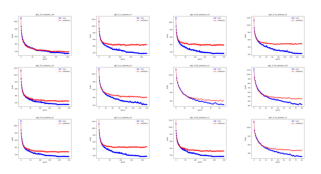

In [335]:
gb1_file_path = '/Users/sebs_mac/round_3/gb1/clustering/'
figure_name = "gb1_cluster_loss.png"

plot_clustering_loss(gb1_file_path, figure_name, 3, 4)

#### GB1 clustering results - metrics: 14 replicates

In [341]:
gb1_all_cluster_results = combine_clustering_replicates(gb1_file_path)
gb1_all_cluster_results.tail()


(56, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
51,./gb1_0.15_extants_r13/,0.134428,0.241966,0.157249,0.662434,0.913455
52,./gb1_0.0_extants_r14/,0.164788,0.245179,0.106065,0.686068,0.928708
53,./gb1_0.1_extants_r14/,0.070229,0.187132,0.041692,0.618250,0.926138
54,./gb1_0.05_extants_r14/,0.155650,0.276379,0.198023,0.699519,0.896778
55,./gb1_0.15_extants_r14/,0.096356,0.213578,0.039692,0.636394,0.847121


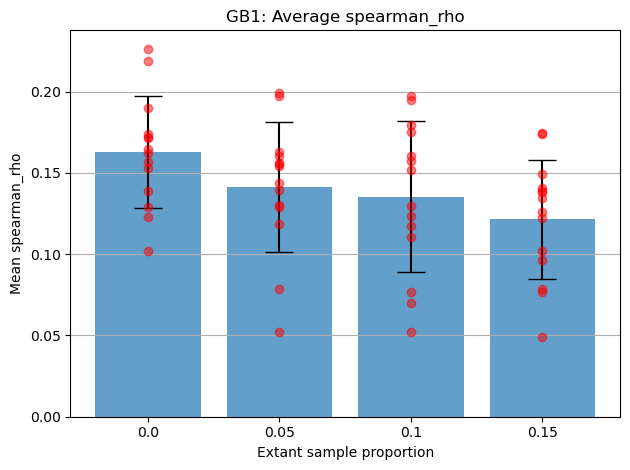

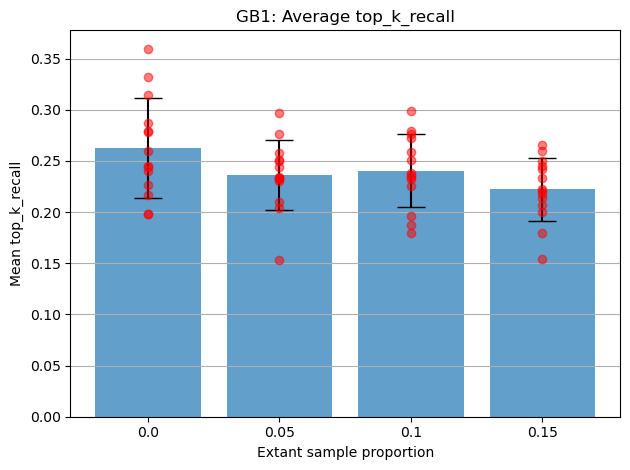

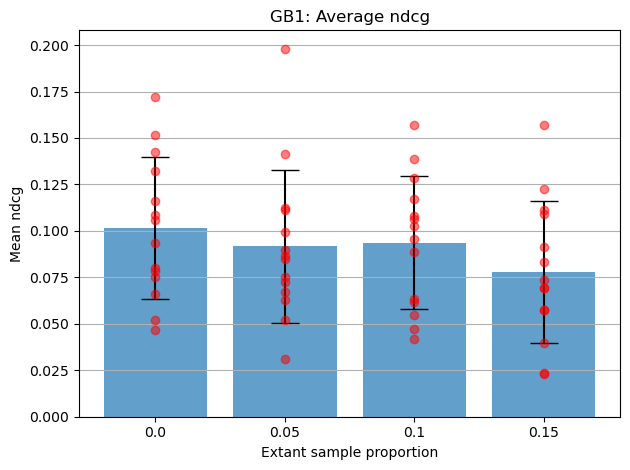

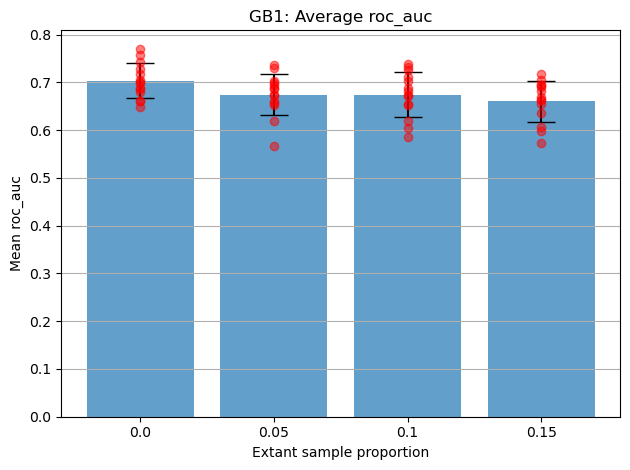

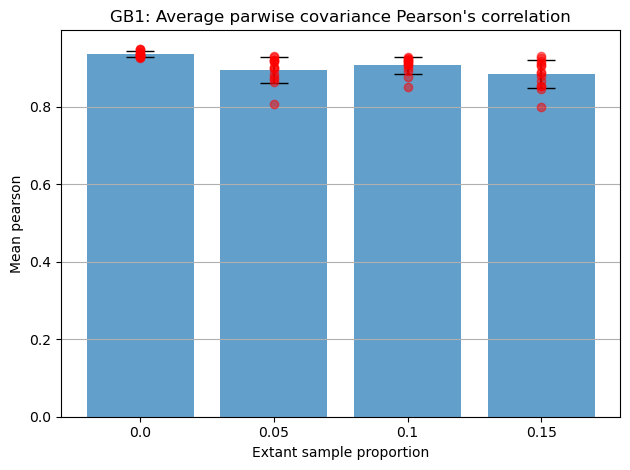

In [358]:
plot_clustering_metrics(gb1_all_cluster_results, "GB1")

#### GB1 Standard - loss

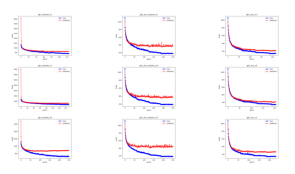

In [351]:
gb1_std_file_path = '/Users/sebs_mac/round_3/gb1/standard/'
plot_standard_loss(gb1_std_file_path, "gb1_std_loss.png")

#### GB1 - standard results - metrics: 14 replicates

In [353]:
# #all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
gb1_all_std_results =combine_standard_replicates(gb1_std_file_path)
gb1_all_std_results.head()

(45, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./gb1_extants_r1/,-0.111367,0.018345,0.000321,0.332160,NaN
1,./gb1_anc_extants_r1/,0.143135,0.268814,0.109802,0.691785,0.935870
2,./gb1_anc_r1/,0.161992,0.197576,0.063778,0.698950,0.898811
3,./gb1_extants_r2/,-0.004712,0.164100,0.137377,0.445191,NaN
4,./gb1_anc_extants_r2/,0.094319,0.220809,0.050347,0.651090,0.920295


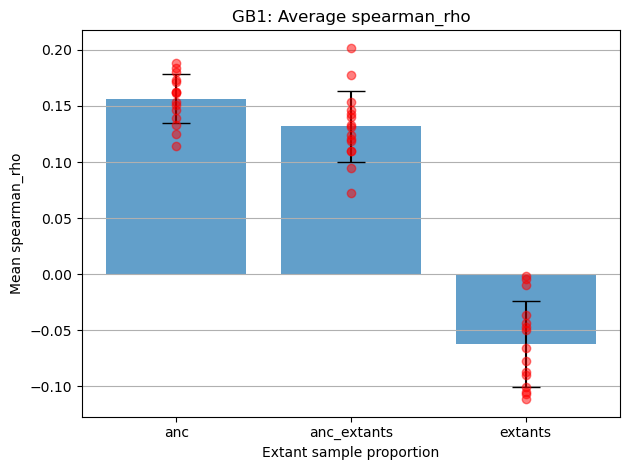

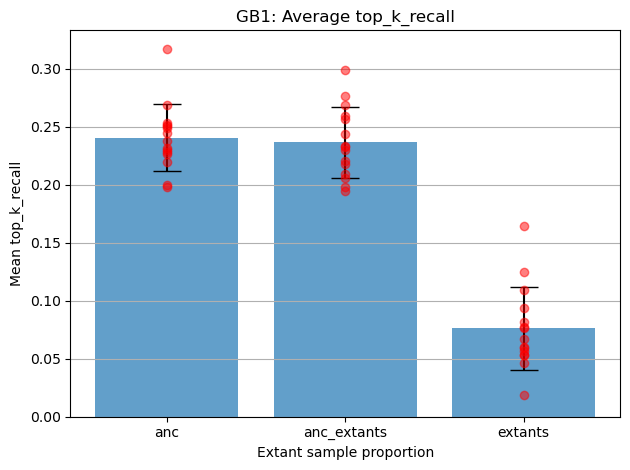

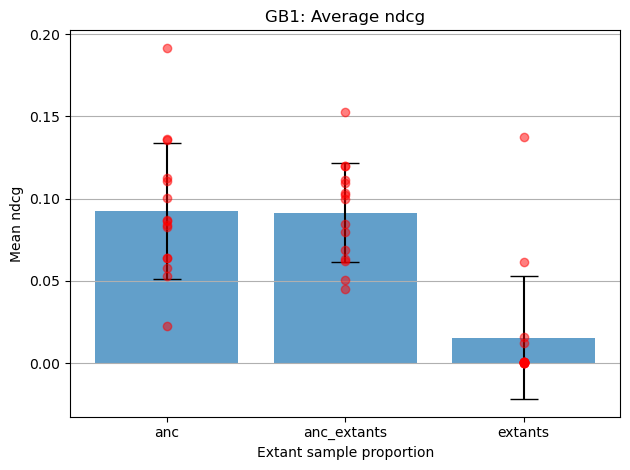

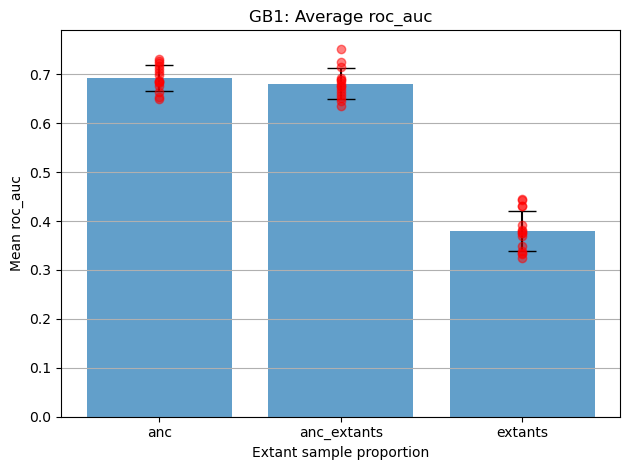

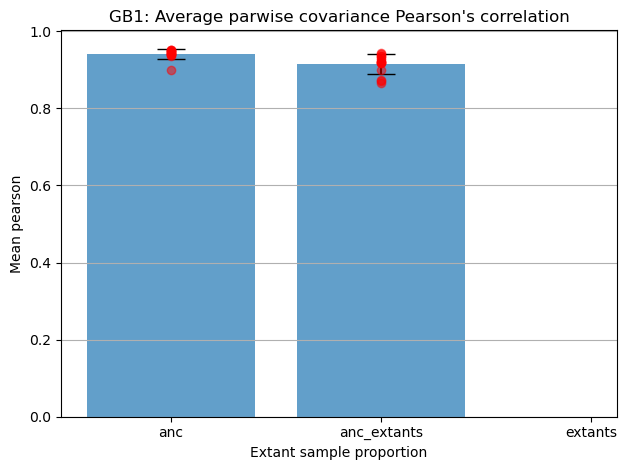

In [359]:
plot_standard_metrics(gb1_all_std_results, "GB1")

# A4 human clustering 

#### Getting cluster replicates

In [ ]:
# this is the dataframe where all sampling will take place from, indices that are sampled will refer to this dataset
a4_aln: pd.DataFrame = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/a4/encoded_weighted/a4_ancestors_extants_encoded_weighted_no_dupes.pkl")
#aln = aln.sample(frac=0.2)
print(a4_aln.shape)
a4_aln.head()

# get into numeric form for quicker processing 
a4_msa, seq_key, key_label = st.convert_msa_numpy_array(a4_aln)
a4_msa.shape


In [ ]:
# read the mmSeqs clustering output 
results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/a4/mmseqs_clustering/a4_an_ex_cluster.tsv", sep="\t", header=None)
results.columns = ["cluster", "sequence"]
mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = results["sequence"].apply(mark_ancestors)
results["is_ancestor"] = is_ancestor

representative_ids = results["cluster"].unique()
# subsets of the dataframes based on the cluster it belongs too 
clusters = [results.loc[results["cluster"] == cluster] for cluster in representative_ids]
representative_ids.shape

In [ ]:

SAMPLE_SIZE = 10000
extant_proportions = [0.0, 0.05, 0.1, 0.15, 0.2]


aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/a4/alns/a4_ancestors_extants_no_dupes.pkl")

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()

    for r in range(1, 16):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)
        test[f"rep_{r}"] = indices

    test.to_csv(f"a4_{p}_replicates.csv", index=False)
#st.write_fasta_file(f"./clusters/gb1_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta", sample_seqs)

#### A4 clustering results - loss

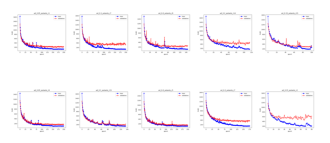

In [310]:
a4_file_path = '/Users/sebs_mac/round_3/a4/clustering/'
figure_name = "a4_cluster_loss.png"

plot_clustering_loss(a4_file_path, figure_name, rows=2, columns=5)

#### A4 clustering results - metrics: 15 replicates

In [313]:
a4_all_cluster_results = combine_clustering_replicates(a4_file_path)
a4_all_cluster_results

(70, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./a4_0.05_extants_r1/,0.138540,0.151147,0.635140,0.574487,0.977421
1,./a4_0.1_extants_r1/,0.186079,0.159244,0.691034,0.594088,0.975649
2,./a4_0.0_extants_r1/,0.168383,0.153171,0.616005,0.584995,0.977336
3,./a4_0.2_extants_r1/,0.284806,0.157220,0.579260,0.645482,0.976282
4,./a4_0.15_extants_r1/,0.096696,0.153846,0.624516,0.547648,0.969606
...,...,...,...,...,...,...
65,./a4_0.05_extants_r14/,0.173083,0.161943,0.612077,0.586992,0.977747
66,./a4_0.1_extants_r14/,0.147125,0.139676,0.556916,0.579365,0.975586
67,./a4_0.0_extants_r14/,0.126225,0.163293,0.617729,0.557104,0.974912
68,./a4_0.2_extants_r14/,0.103510,0.158570,0.586450,0.555728,0.967001


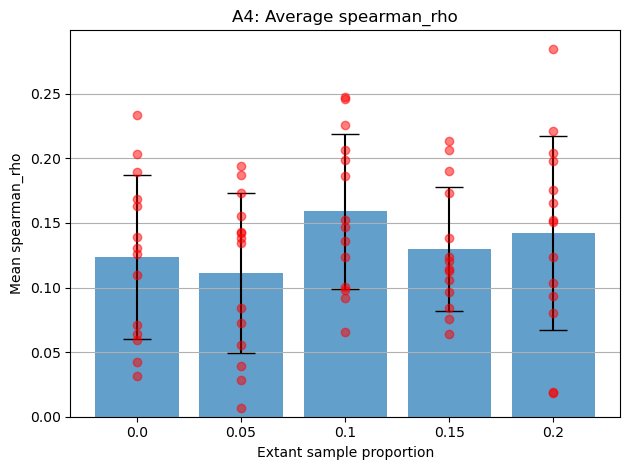

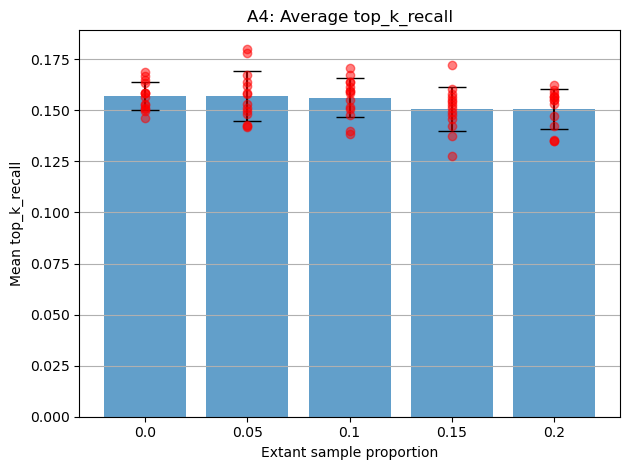

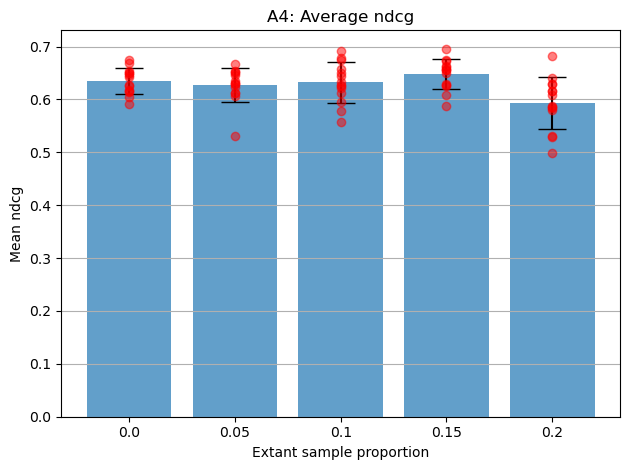

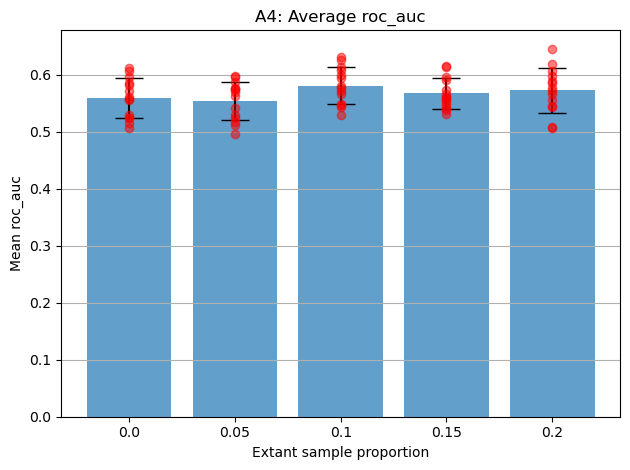

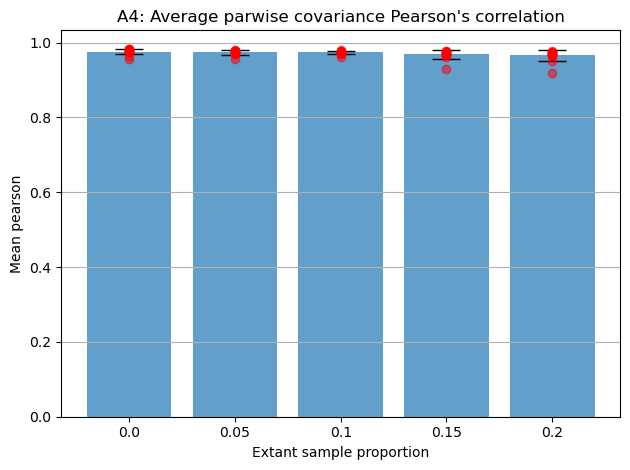

In [315]:
plot_clustering_metrics(a4_all_cluster_results, "A4")

#### A4 Standard results - loss

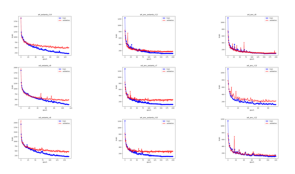

In [317]:
a4_std_file_path = '/Users/sebs_mac/round_3/a4/standard/'
plot_standard_loss(a4_std_file_path, "a4_std_loss.png")

#### A4 Standard results - metrics: 15 replicates

In [318]:
a4_all_std_results = combine_standard_replicates(a4_std_file_path)
a4_all_std_results.head()

(45, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./a4_extants_r1/,0.110263,0.149798,0.573881,0.549230,0.964179
1,./a4_anc_extants_r1/,0.166466,0.155196,0.618149,0.584469,0.981897
2,./a4_anc_r1/,0.263853,0.166667,0.615233,0.631327,0.982763
3,./a4_extants_r2/,0.125608,0.170715,0.598078,0.560378,0.962057
4,./a4_anc_extants_r2/,0.214376,0.159244,0.675792,0.610865,0.981946


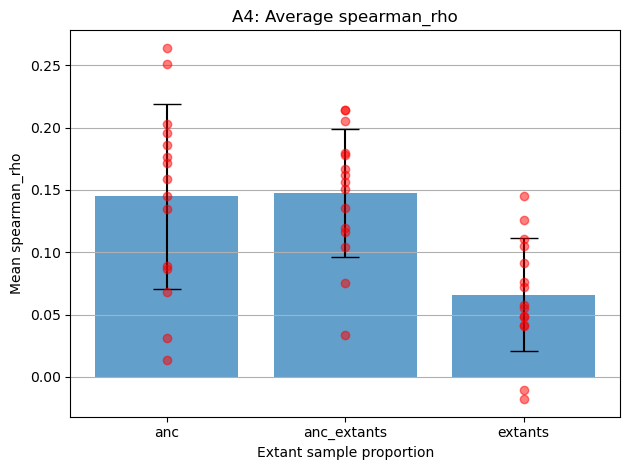

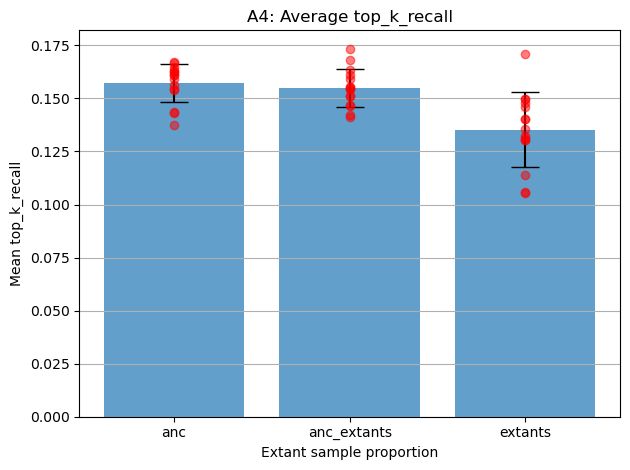

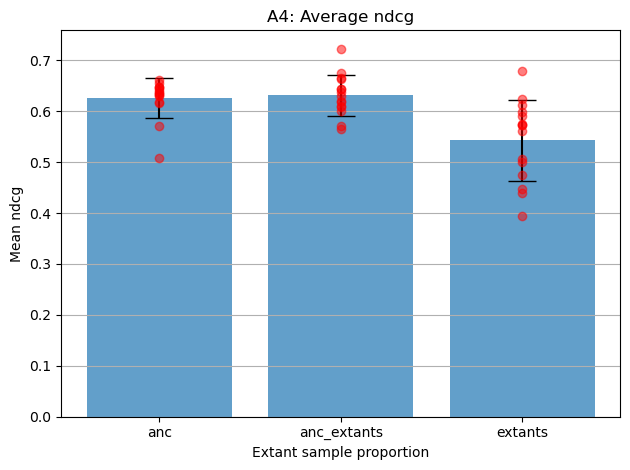

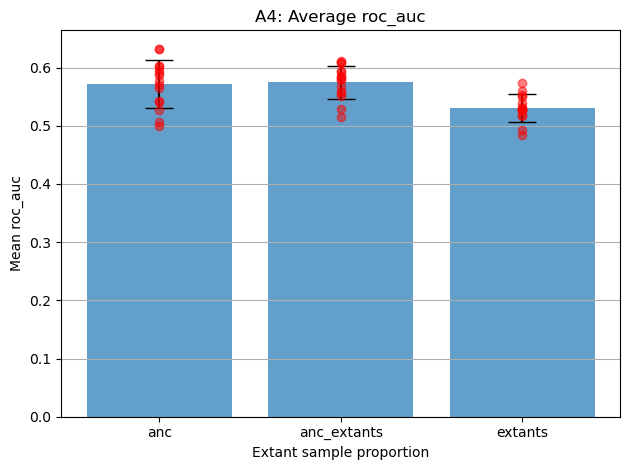

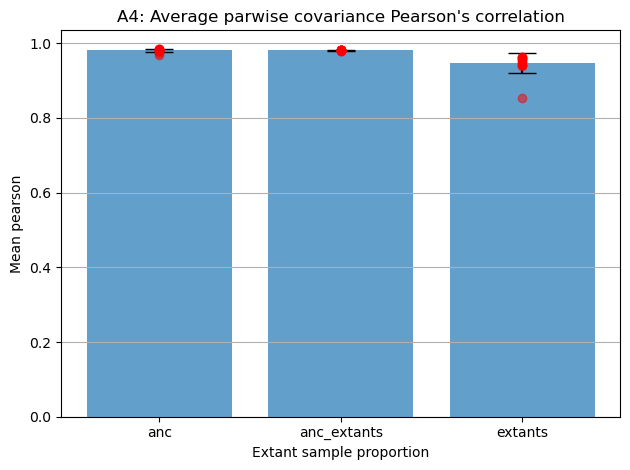

In [319]:
plot_standard_metrics(a4_all_std_results, "A4")

# GCN4 clustering

#### GCN4 - getting cluster replicates

In [ ]:
clustering_results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/mmseqs_clustering/gcn4_an_ex_cluster.tsv", sep="\t", header=None)
clustering_results.columns = ["cluster", "sequence"]

mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = clustering_results["sequence"].apply(mark_ancestors)
clustering_results["is_ancestor"] = is_ancestor

representative_ids = clustering_results["cluster"].unique()

clustering_results
# divide the sequences into their clusters
clusters = [clustering_results.loc[clustering_results["cluster"] == rep] for rep in representative_ids]
len(clusters)

In [ ]:
import random
import evoVAE.utils.seq_tools as st


SAMPLE_SIZE = 5000
extant_proportions = [0.06, 0.04, 0.02, 0.0]


aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants_no_dupes.pkl")

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()

    for r in range(1, 16):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)
        test[f"rep_{r}"] = indices


    test.to_csv(f"gcn4_{p}_replicates.csv", index=False)
       


In [ ]:
import os
import pandas as pd

DATA_PATH = "/Users/sebs_mac/uni_OneDrive/honours/data/clustering_data/gcn4/"

#df_list = [pd.read_csv(file + "/_zero_shot.csv") for file in os.listdir(DATA_PATH)]
df_list = [pd.read_csv((DATA_PATH + str(file) + "/_zero_shot.csv")) for file in os.listdir(DATA_PATH) if str(file) != ".DS_Store"]

all_data = pd.read_csv("gcn4_cluster_sampling_results.csv")
all_data.drop(columns=["Unnamed: 0"], inplace=True)

get_rep = lambda x: x.split("_")[1] 
get_ex = lambda x: x.split("_")[11] 

rep = all_data["unique_id"].apply(get_rep)
ext_prop = all_data["unique_id"].apply(get_ex)
all_data["replicate"] = rep
all_data["extant_prop"] = ext_prop

a4_extant_proportions = all_data["extant_prop"].unique()
a4_extant_proportions.sort()

subsets = [all_data.loc[all_data["extant_prop"] == prop] for prop in a4_extant_proportions]



#### GCN4 clustering results - loss

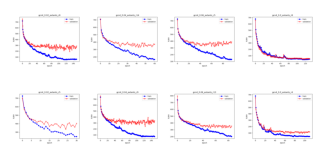

In [324]:
gcn4_file_path = '/Users/sebs_mac/round_3/gcn4/clustering/'
figure_name = "gcn4_cluster_loss.png"

plot_clustering_loss(gcn4_file_path, figure_name, rows=2, columns=4)

#### GCN4 clustering results - metrics: 15 replicates

In [326]:
gcn4_all_cluster_results = combine_clustering_replicates(gcn4_file_path)
gcn4_all_cluster_results.head()

(56, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./gcn4_0.02_extants_r1/,0.183935,0.174242,0.407155,0.604595,0.852807
1,./gcn4_0.04_extants_r1/,0.194688,0.208333,0.465694,0.607284,0.902832
2,./gcn4_0.06_extants_r1/,0.179467,0.204545,0.441030,0.597858,0.846406
3,./gcn4_0.0_extants_r1/,0.197448,0.178030,0.436945,0.609567,0.845500
4,./gcn4_0.02_extants_r2/,0.197825,0.174242,0.390362,0.610536,0.848435


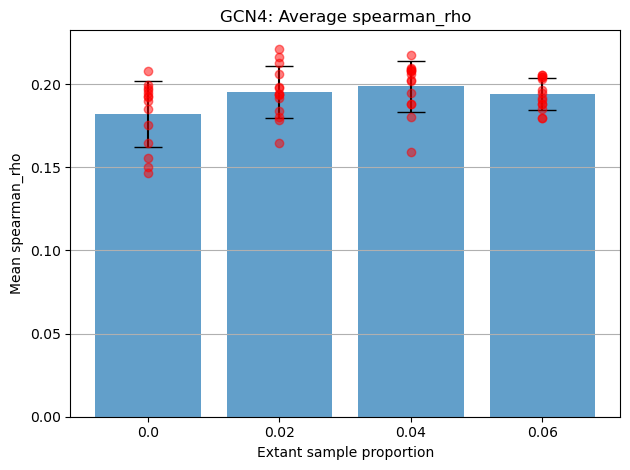

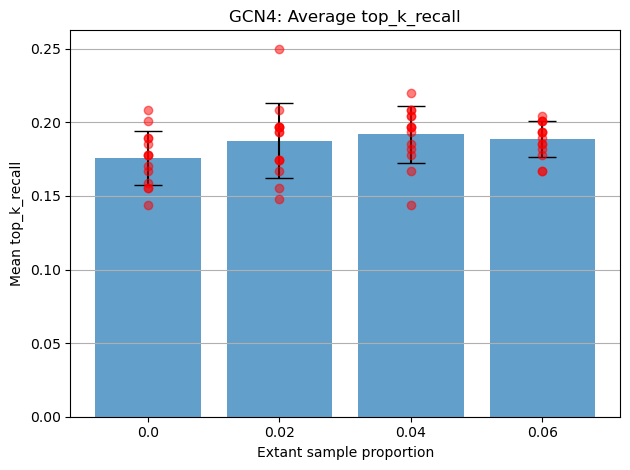

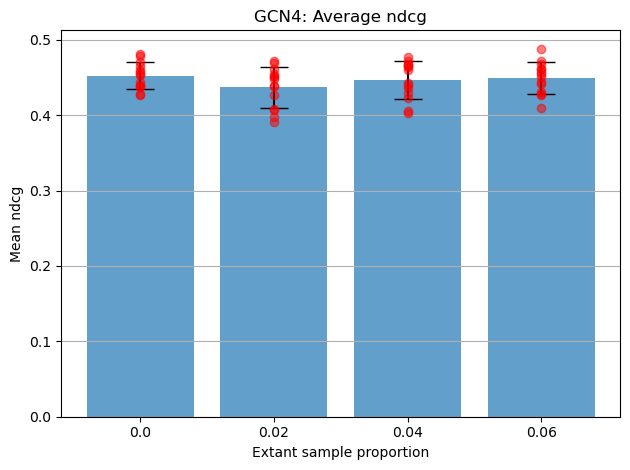

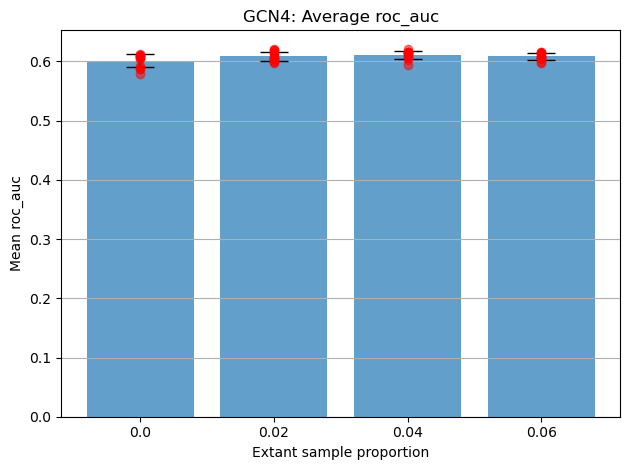

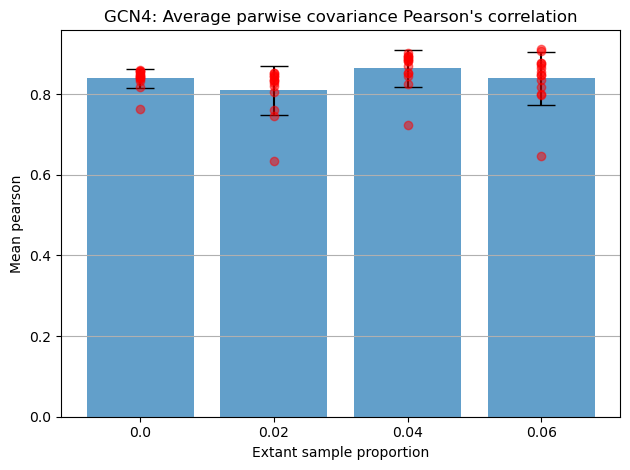

In [327]:
plot_clustering_metrics(gcn4_all_cluster_results, "GCN4")

#### GCN4 Standard results - loss

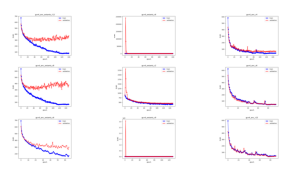

In [328]:
gcn4_std_file_path = '/Users/sebs_mac/round_3/gcn4/standard/'
plot_standard_loss(gcn4_std_file_path, "gcn4_std_loss.png")

#### GCN4 Standard results - metrics: 15 replicates

In [329]:
gcn4_all_std_results = combine_standard_replicates(gcn4_std_file_path)
gcn4_all_std_results.head()

(45, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./gcn4_anc_extants_r1/,0.209331,0.204545,0.431173,0.615801,0.912234
1,./gcn4_extants_r1/,0.118681,0.132576,0.442044,0.565982,0.551964
2,./gcn4_anc_r1/,0.204014,0.208333,0.486287,0.611504,0.905354
3,./gcn4_anc_extants_r2/,0.191936,0.196970,0.401065,0.609163,0.896647
4,./gcn4_extants_r2/,0.139401,0.132576,0.396106,0.579438,0.639471


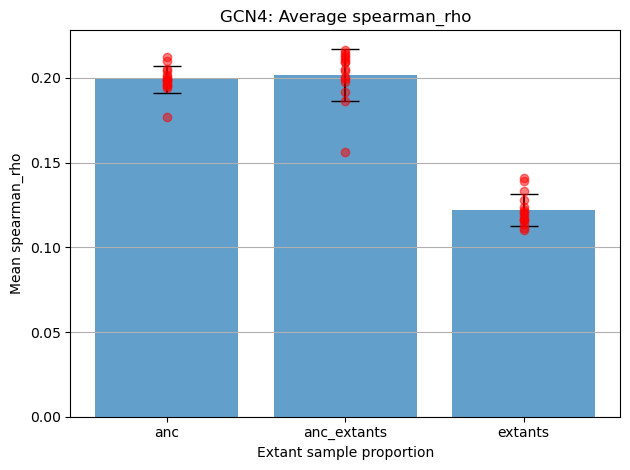

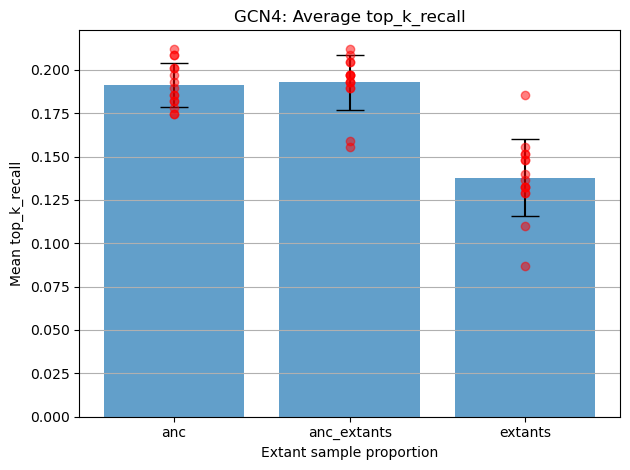

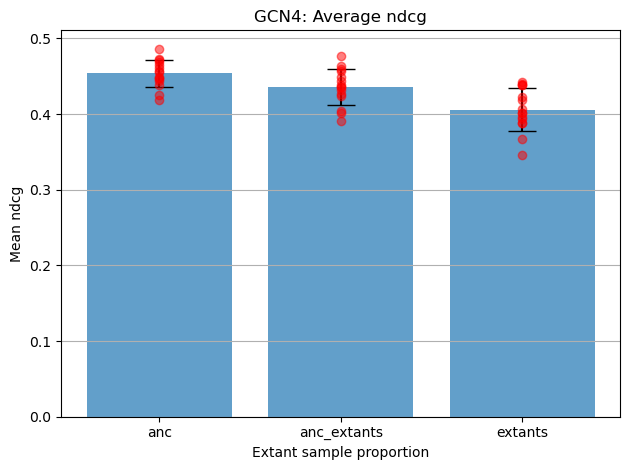

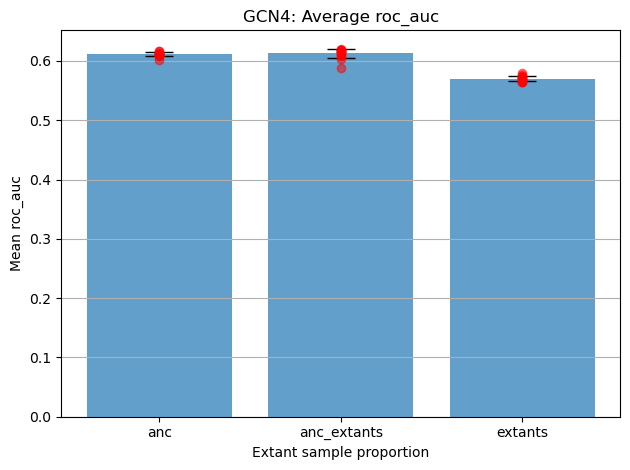

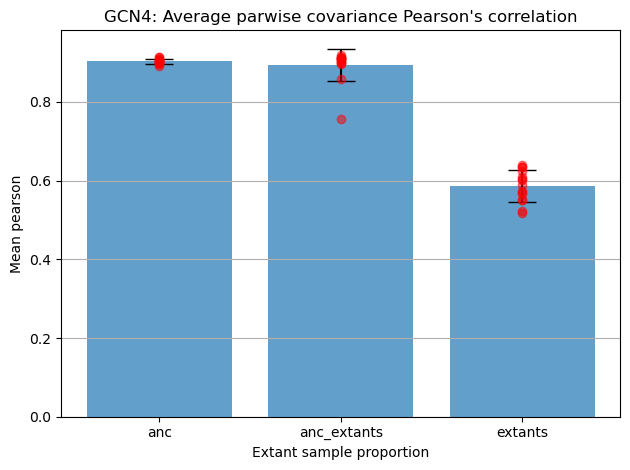

In [330]:
plot_standard_metrics(gcn4_all_std_results, "GCN4")